In [ ]:
#@title Installation of necessary packages

!pip install -q jax

!pip install -q hgq2
!pip install -q hls4ml
!pip install -q da4ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import random

# JAX runs the fastest for hgq in general based on our experience
# If you don't have jax, or if you want to use another backend, you can change this to 'tensorflow' or 'torch'
os.environ['KERAS_BACKEND'] = 'jax'
# tested for tensorflow, jax, and torch.
# For the best performance, we recommend using jax, or tensorflow with XLA (jit compile) enabled.
# Jit compilation for torch (torch dynamo) is not supported yet (may or may not work)

import keras
import numpy as np
from matplotlib import pyplot as plt

from hgq.config import QuantizerConfig, QuantizerConfigScope
from hgq.layers import QDenseT
from hgq.utils.sugar import FreeEBOPs, PBar, BetaScheduler, ParetoFront

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
#@title **STEP 2 Download data**
#@markdown  Download data from openml and cache it. Should only take a few seconds

import pickle as pkl
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def get_data(data_path: Path, seed=42):
    if not os.path.exists(data_path):
        print('Downloading data...', end='')
        data = fetch_openml('hls4ml_lhc_jets_hlf')
        buf = pkl.dumps(data)
        with open(data_path, 'wb') as f:
            f.write(buf)
        print('Done')
    else:
        os.makedirs(data_path.parent, exist_ok=True)
        with open(data_path, 'rb') as f:
            buf = f.read()
            data = pkl.loads(buf)

    X, y = data['data'], data['target']
    codecs = {'g': 0, 'q': 1, 't': 4, 'w': 2, 'z': 3}
    y = np.array([codecs[i] for i in y])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_val, X_test, y_train_val, y_test = X_train_val.astype(np.float32), X_test.astype(np.float32), y_train_val, y_test

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    X_train_val = X_train_val.astype(np.float32)
    y_train_val = y_train_val.astype(np.float32)

    return X_train_val, X_test, y_train_val, y_test

X_train, X_test, y_train, y_test = get_data(Path('/tmp/inp_data.pkl'))

In [ ]:
from hgq.utils.sugar import Dataset

#@markdown Where the data is located. Since we use TPU for training on this notebook, pre-load them on TPU makes training faster.
#@markdown - If you are using a GPU-accelerated machine, replace tpu by 'gpu:#device'.
#@markdown - For larger datasets, consider using cpu or a custom dataloader
#@markdown - Training directly on numpy array is **not** recommended (bad perf + vram overhead)

device = 'tpu:0' #@param ['cpu:0', 'tpu:0']

#@markdown Using huge batchsize for better accelerator util.

batch_size = 33200 #@param {type:"integer"}

dataset_train = Dataset(X_train, y_train, batch_size=33200, device=device)
dataset_test = Dataset(X_test, y_test, batch_size=33200, device=device)

In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
with QuantizerConfigScope(k0=1, b0=6, i0=2):
    with QuantizerConfigScope(place='table', homogeneous_axis=(0,)):
        inp = keras.layers.Input((16,))
        out = keras.layers.BatchNormalization()(inp)
        out = QDenseT(16, 1, 8, 'tanh')(inp)
        out = QDenseT(5, 1, 8, 'tanh')(out)

model = keras.Model(inp, out)

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(opt, loss, metrics=['accuracy'], jit_compile=True, steps_per_execution=4)

In [ ]:
pbar = PBar('loss: {loss:.3f}/{val_loss:.3f} - acc: {accuracy:.3f}/{val_accuracy:.3f} - beta: {beta:.1e}')
ebops = FreeEBOPs()
beta_sched = BetaScheduler(lambda ep:3e-7 * 500 ** (ep/5000))
pareto = ParetoFront('/tmp/ckpts', ['val_accuracy', 'ebops'], [1,-1], fname_format='epoch={epoch}.weights.h5')
callbacks = [ebops, beta_sched, pbar, pareto]

In [ ]:
#@title Use fp32 precision for underlying matmul
#@markdown On TPU, jax uses bf16 by default. This causes mismatches between software and fixed point models

#@markdown Actual performance degredation will still be minimal, but it could be a footgun

#@markdown The same issue happens when using GPUs, also with tf/torch.
#@markdown - In most cases, TF32 by default, better but still on the same road

#@markdown jax: `jax.config.update('jax_default_matmul_precision', 'highest')`

#@markdown tf: `tf.config.experimental.enable_tensor_float_32_execution(False)`

#@markdown torch: `torch.set_float32_matmul_precision('highest')`

import jax

jax.config.update('jax_default_matmul_precision', 'highest')

In [ ]:
history = model.fit(dataset_train, epochs=5000, validation_data=dataset_test, verbose=0, callbacks=callbacks)

loss: 0.824/0.718 - acc: 0.748/0.746 - beta: 1.5e-04 - EBOPs: 739: 100%|██████████| 5000/5000 [04:12<00:00, 19.77epoch/s]


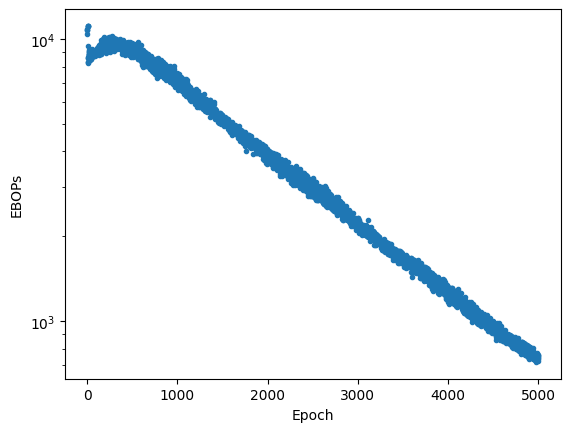

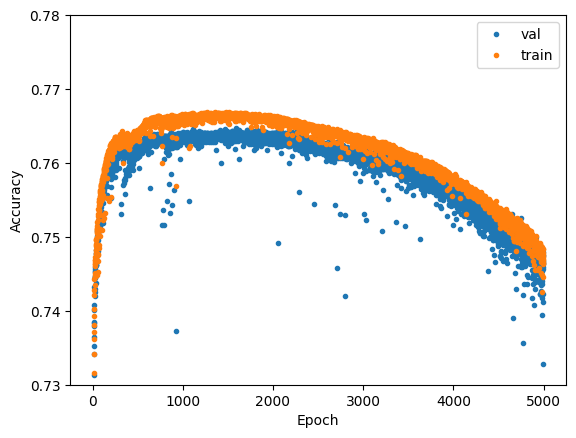

In [ ]:
plt.plot(history.history['ebops'], '.')
plt.ylabel('EBOPs')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['val_accuracy'], '.', label='val')
plt.plot(history.history['accuracy'], '.', label='train')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim(0.73, 0.78)
plt.xlabel('Epoch')
plt.show()

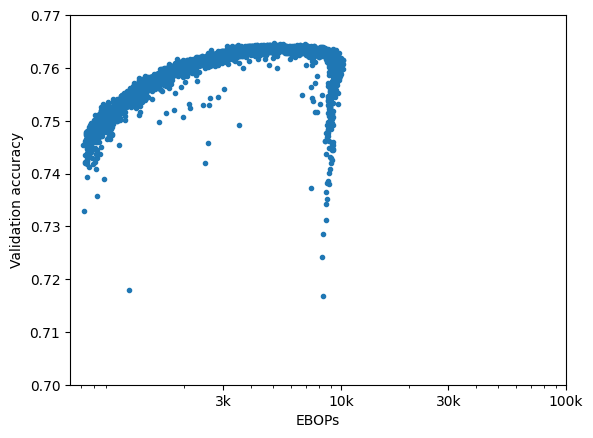

In [ ]:
plt.plot(history.history['ebops'], history.history['val_accuracy'], '.')
plt.xscale('log')
plt.xlabel('EBOPs')
plt.ylabel('Validation accuracy')
plt.ylim(0.7, 0.77)
plt.xticks([3000, 10000, 30000, 100000], ['3k', '10k', '30k', '100k'])
plt.show()

In [ ]:
model.load_weights(pareto.paths[-44]) # Load weights of a model on the val_accuracy-ebops Pareto Frontier.

In [ ]:
# If WRAP overflow mode is used for datalane, one needs to calibrate the number of integer bits
# before deployment to avoid overflow. This can be done by running the following code:
# Notice that `cover_factor` in HGQ v1 is not yet supported in this version.

from hgq.utils import trace_minmax

trace_minmax(model, dataset_train)

1758

In [ ]:
from da4ml.converter import trace_model
from da4ml.trace import comb_trace
from da4ml.codegen import RTLModel

In [ ]:
os.makedirs('/tmp/projects', exist_ok=True)

In [ ]:
from tqdm import tqdm

pbar = tqdm(pareto.paths)
for path in pbar:
    model.load_weights(path)
    ebops = trace_minmax(model, dataset_train)
    _inp, _out = trace_model(model)
    comb_logic = comb_trace(_inp, _out)
    epoch = int(path.name.split('.', 1)[0].split('=')[-1])
    rtl_model = RTLModel(comb_logic, 'hgqlut', f'/tmp/projects/epoch={epoch}', latency_cutoff=1, clock_period=1, clock_uncertainty=0)
    acc = float(np.mean(np.argmax(comb_logic.predict(X_test), axis=1) == y_test))
    cost = rtl_model._solution.cost
    rtl_model.write({'comb_metric': acc, 'ebops': ebops})
    pbar.set_description(f'acc={acc:.2%} - ebops={ebops:.0f} - cost={cost:.0f}')


acc=74.80% - ebops=757 - cost=560: 100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


In [ ]:
!da4ml report /tmp/projects/*

| epoch | flavor  | clock_pe | ebops | cost   | latency | comb_met |
|-------|---------|----------|-------|--------|---------|----------|
| 1593  | verilog | 1.0      | 5014  | 5526.0 | 12      | 0.764669 |
| 1611  | verilog | 1.0      | 4727  | 5198.0 | 12      | 0.764428 |
| 1825  | verilog | 1.0      | 4252  | 4686.0 | 11      | 0.764428 |
| 1853  | verilog | 1.0      | 4225  | 4713.2 | 11      | 0.764355 |
| 1714  | verilog | 1.0      | 4764  | 5268.8 | 12      | 0.764349 |
| 2085  | verilog | 1.0      | 3830  | 4228.0 | 11      | 0.764301 |
| 2213  | verilog | 1.0      | 3555  | 3904.0 | 11      | 0.764163 |
| 2258  | verilog | 1.0      | 3308  | 3623.8 | 11      | 0.764151 |
| 2609  | verilog | 1.0      | 2987  | 3227.0 | 11      | 0.763410 |
| 2711  | verilog | 1.0      | 2745  | 2957.8 | 11      | 0.762916 |
| 2716  | verilog | 1.0      | 2778  | 2988.4 | 11      | 0.762319 |
| 2820  | verilog | 1.0      | 2423  | 2626.0 | 10      | 0.762205 |
| 2884  | verilog | 1.0      | 248

# Synthemizing the model

The command for vivado is `vivado -mode batch -source build_vivado_prj.tcl` for each individual model. If you have gnu parallel, you can run

```bash
ls -d epoch=* | parallel -j $n_jobs `cd {} && vivado -mode batch -source build_vivado_prj.tcl > synth.log
```

for batch synthesis.

# Results after OOC P&R

```
> da4ml report *
| epoch | flavor  | actual_period | clock_period | ebops | cost   | latency | DSP | LUT  | FF   | comb_metric | Fmax(MHz) | latency(ns) |
|-------|---------|---------------|--------------|-------|--------|---------|-----|------|------|-------------|-----------|-------------|
| 1593  | verilog | 1.003         | 1.0          | 5014  | 5526.0 | 12      | 0   | 4840 | 4025 | 0.764668675 | 997.00897 | 12.036      |
| 1611  | verilog | 0.997         | 1.0          | 4727  | 5198.0 | 12      | 0   | 4843 | 3975 | 0.764427711 | 1003.0090 | 11.964      |
| 1825  | verilog | 0.996         | 1.0          | 4252  | 4686.0 | 11      | 0   | 4424 | 3653 | 0.764427711 | 1004.0161 | 10.956      |
| 1853  | verilog | 0.998         | 1.0          | 4225  | 4713.2 | 11      | 0   | 4403 | 3628 | 0.764355422 | 1002.0040 | 10.978      |
| 1714  | verilog | 1.031         | 1.0          | 4764  | 5268.8 | 12      | 0   | 4745 | 3891 | 0.764349398 | 969.93210 | 12.372      |
| 2085  | verilog | 0.984         | 1.0          | 3830  | 4228.0 | 11      | 0   | 3961 | 3283 | 0.764301205 | 1016.2602 | 10.824      |
| 2213  | verilog | 0.997         | 1.0          | 3555  | 3904.0 | 11      | 0   | 3720 | 3116 | 0.764162651 | 1003.0090 | 10.967      |
| 2258  | verilog | 1.0           | 1.0          | 3308  | 3623.8 | 11      | 0   | 3507 | 2961 | 0.764150602 | 1000.0    | 11.0        |
| 2609  | verilog | 0.981         | 1.0          | 2987  | 3227.0 | 11      | 0   | 3013 | 2647 | 0.763409639 | 1019.3680 | 10.791      |
| 2711  | verilog | 0.971         | 1.0          | 2745  | 2957.8 | 11      | 0   | 2879 | 2565 | 0.762915663 | 1029.8661 | 10.681      |
| 2716  | verilog | 0.964         | 1.0          | 2778  | 2988.4 | 11      | 0   | 2875 | 2472 | 0.762319277 | 1037.3444 | 10.604      |
| 2820  | verilog | 0.982         | 1.0          | 2423  | 2626.0 | 10      | 0   | 2693 | 2373 | 0.762204819 | 1018.3299 | 9.82        |
| 2884  | verilog | 0.97          | 1.0          | 2485  | 2672.2 | 10      | 0   | 2717 | 2388 | 0.76213253  | 1030.9278 | 9.7         |
| 2922  | verilog | 0.959         | 1.0          | 2450  | 2634.2 | 10      | 0   | 2548 | 2242 | 0.762096386 | 1042.7529 | 9.59        |
| 2947  | verilog | 0.994         | 1.0          | 2225  | 2374.0 | 10      | 0   | 2448 | 2179 | 0.761771084 | 1006.0362 | 9.94        |
| 2968  | verilog | 0.986         | 1.0          | 2385  | 2515.0 | 10      | 0   | 2562 | 2241 | 0.761759036 | 1014.1988 | 9.86        |
| 3020  | verilog | 0.967         | 1.0          | 2122  | 2284.4 | 10      | 0   | 2386 | 2182 | 0.761698795 | 1034.1262 | 9.67        |
| 3193  | verilog | 0.989         | 1.0          | 1970  | 2069.6 | 10      | 0   | 2203 | 1956 | 0.761644578 | 1011.1223 | 9.89        |
| 3299  | verilog | 0.959         | 1.0          | 1858  | 1921.6 | 10      | 0   | 2042 | 1878 | 0.760951807 | 1042.7529 | 9.59        |
| 3362  | verilog | 0.995         | 1.0          | 1784  | 1852.8 | 10      | 0   | 1951 | 1805 | 0.760759036 | 1005.0251 | 9.95        |
| 3441  | verilog | 0.959         | 1.0          | 1758  | 1818.4 | 10      | 0   | 1909 | 1797 | 0.760114458 | 1042.7529 | 9.59        |
| 3518  | verilog | 0.952         | 1.0          | 1678  | 1745.0 | 10      | 0   | 1825 | 1765 | 0.759981928 | 1050.4202 | 9.52        |
| 3456  | verilog | 0.963         | 1.0          | 1742  | 1793.6 | 10      | 0   | 1924 | 1840 | 0.759909639 | 1038.4216 | 9.63        |
| 3573  | verilog | 0.976         | 1.0          | 1668  | 1711.8 | 10      | 0   | 1801 | 1727 | 0.759825301 | 1024.5902 | 9.76        |
| 3575  | verilog | 0.981         | 1.0          | 1615  | 1652.0 | 9       | 0   | 1768 | 1630 | 0.759090361 | 1019.3680 | 8.829       |
| 3629  | verilog | 0.946         | 1.0          | 1588  | 1619.2 | 10      | 0   | 1668 | 1636 | 0.75896988  | 1057.0825 | 9.46        |
| 3697  | verilog | 0.958         | 1.0          | 1508  | 1515.8 | 9       | 0   | 1629 | 1578 | 0.758855422 | 1043.8413 | 8.622       |
| 3703  | verilog | 0.949         | 1.0          | 1545  | 1559.6 | 9       | 0   | 1634 | 1569 | 0.758740964 | 1053.7408 | 8.541       |
| 3785  | verilog | 0.949         | 1.0          | 1426  | 1417.4 | 9       | 0   | 1561 | 1502 | 0.758524096 | 1053.7408 | 8.541       |
| 3892  | verilog | 0.89          | 1.0          | 1351  | 1323.0 | 9       | 0   | 1429 | 1639 | 0.758162651 | 1123.5955 | 8.01        |
| 4034  | verilog | 0.95          | 1.0          | 1212  | 1139.0 | 9       | 0   | 1251 | 1479 | 0.75713253  | 1052.6316 | 8.55        |
| 4029  | verilog | 0.95          | 1.0          | 1303  | 1250.8 | 9       | 0   | 1304 | 1302 | 0.756644578 | 1052.6316 | 8.55        |
| 4139  | verilog | 0.943         | 1.0          | 1160  | 1076.4 | 9       | 0   | 1215 | 1246 | 0.756295181 | 1060.4454 | 8.487       |
| 4157  | verilog | 0.93          | 1.0          | 1150  | 1069.8 | 9       | 0   | 1181 | 1195 | 0.755680723 | 1075.2688 | 8.37        |
| 4096  | verilog | 0.949         | 1.0          | 1169  | 1095.2 | 9       | 0   | 1230 | 1248 | 0.755614458 | 1053.7408 | 8.541       |
| 4182  | verilog | 0.883         | 1.0          | 1136  | 1055.0 | 9       | 0   | 1161 | 1379 | 0.755246988 | 1132.5028 | 7.947       |
| 4215  | verilog | 0.943         | 1.0          | 1168  | 1085.8 | 9       | 0   | 1191 | 1204 | 0.755228916 | 1060.4454 | 8.487       |
| 4212  | verilog | 0.964         | 1.0          | 1086  | 1012.0 | 8       | 0   | 1145 | 1112 | 0.754963855 | 1037.3444 | 7.712       |
| 4263  | verilog | 0.972         | 1.0          | 1091  | 997.8  | 9       | 0   | 1084 | 1287 | 0.754915663 | 1028.8066 | 8.748       |
| 4244  | verilog | 0.916         | 1.0          | 1105  | 1008.6 | 9       | 0   | 1102 | 1321 | 0.754825301 | 1091.7031 | 8.244       |
| 4250  | verilog | 0.916         | 1.0          | 1104  | 1023.6 | 9       | 0   | 1138 | 1186 | 0.75473494  | 1091.7031 | 8.244       |
| 4301  | verilog | 0.917         | 1.0          | 1064  | 943.0  | 9       | 0   | 1062 | 1291 | 0.754662651 | 1090.5125 | 8.253       |
| 4401  | verilog | 0.914         | 1.0          | 1055  | 908.2  | 9       | 0   | 1003 | 1180 | 0.754078313 | 1094.0919 | 8.226       |
| 4351  | verilog | 0.876         | 1.0          | 1042  | 903.4  | 9       | 0   | 1026 | 1233 | 0.754060241 | 1141.5525 | 7.884       |
| 4512  | verilog | 0.932         | 1.0          | 975   | 814.2  | 8       | 0   | 947  | 1092 | 0.753481928 | 1072.9614 | 7.456       |
| 4652  | verilog | 0.915         | 1.0          | 905   | 745.8  | 8       | 0   | 848  | 874  | 0.753090361 | 1092.8962 | 7.32        |
| 4751  | verilog | 0.898         | 1.0          | 877   | 698.2  | 8       | 0   | 810  | 837  | 0.752608434 | 1113.5857 | 7.184       |
| 4676  | verilog | 0.874         | 1.0          | 876   | 720.0  | 8       | 0   | 824  | 957  | 0.751759036 | 1144.1648 | 6.992       |
| 4610  | verilog | 0.894         | 1.0          | 896   | 729.0  | 8       | 0   | 820  | 951  | 0.751349398 | 1118.5682 | 7.152       |
| 4648  | verilog | 0.892         | 1.0          | 884   | 713.0  | 8       | 0   | 854  | 860  | 0.751343373 | 1121.0762 | 7.136       |
| 4775  | verilog | 0.925         | 1.0          | 850   | 681.6  | 8       | 0   | 762  | 802  | 0.751042169 | 1081.0811 | 7.4         |
| 4848  | verilog | 0.867         | 1.0          | 833   | 660.8  | 8       | 0   | 746  | 921  | 0.750162651 | 1153.4025 | 6.936       |
| 4832  | verilog | 0.837         | 1.0          | 805   | 627.6  | 8       | 0   | 781  | 949  | 0.749885542 | 1194.7431 | 6.696       |
| 4855  | verilog | 0.82          | 1.0          | 826   | 652.2  | 8       | 0   | 756  | 926  | 0.749512048 | 1219.5122 | 6.56        |
| 4859  | verilog | 0.827         | 1.0          | 776   | 594.4  | 8       | 0   | 711  | 864  | 0.749186747 | 1209.1898 | 6.616       |
| 4884  | verilog | 0.829         | 1.0          | 781   | 597.0  | 8       | 0   | 711  | 860  | 0.74886747  | 1206.2726 | 6.632       |
| 4876  | verilog | 0.809         | 1.0          | 792   | 617.8  | 8       | 0   | 721  | 883  | 0.748837349 | 1236.0939 | 6.472       |
| 4972  | verilog | 0.828         | 1.0          | 741   | 539.6  | 8       | 0   | 622  | 761  | 0.747993976 | 1207.7295 | 6.624       |
| 4998  | verilog | 0.886         | 1.0          | 757   | 560.2  | 8       | 0   | 688  | 874  | 0.747975904 | 1128.6682 | 7.088       |
| 4983  | verilog | 0.828         | 1.0          | 731   | 541.0  | 8       | 0   | 644  | 827  | 0.747957831 | 1207.7295 | 6.624       |
| 4938  | verilog | 0.817         | 1.0          | 753   | 566.6  | 8       | 0   | 689  | 836  | 0.747933735 | 1223.9902 | 6.536       |
| 4967  | verilog | 0.885         | 1.0          | 733   | 531.0  | 8       | 0   | 626  | 780  | 0.746108434 | 1129.9435 | 7.08        |
| 4965  | verilog | 0.869         | 1.0          | 716   | 518.6  | 8       | 0   | 658  | 802  | 0.745789157 | 1150.7480 | 6.952       |
| 4980  | verilog | 0.945         | 1.0          | 711   | 521.2  | 8       | 0   | 656  | 834  | 0.745415663 | 1058.2011 | 7.56        |
```

In [ ]:
# !cd /tmp && tar -zcf projects.tar.gz projects && mv projects.tar.gz /content/